In [38]:
import pandas as pd
import numpy as np
import math
from google.cloud import bigquery,storage
import datetime
import time
import gc
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.tree import _tree, DecisionTreeClassifier
import joblib

## Config

In [64]:
PROJECT_NAME='cdp-dev-bdfa'
CLTV_PREDICTIONS_TABLE='curated.t_mdl_cltv_predictions'
PREDICTIONS_TABLE='curated.t_mdl_kmeans_predictions'
CHECKPOINTS_TABLE='curated.t_mdl_kmeans_checkpoints'

client = bigquery.Client(project=PROJECT_NAME)

## Loading the data from big query

In [65]:
sql_query = (f"""SELECT ALIVE_PROB,FUTURE_12MO_PURCHASE,Count(CUSTOMER_ID) as SEGMENTS FROM `{CLTV_PREDICTIONS_TABLE}` GROUP BY ALIVE_PROB,FUTURE_12MO_PURCHASE""")
df = client.query(sql_query).to_dataframe()
df.head()

,ALIVE_PROB,FUTURE_12MO_PURCHASE,SEGMENTS
0,0.00,0.00,28762
1,0.01,0.00,789
2,0.11,0.09,208
3,0.07,0.09,181
4,0.05,0.09,172


# Feature Scaling

#### Selected Features

- alive_prob 
- future_12m_purchase

In [66]:
selected_feature=['ALIVE_PROB','FUTURE_12MO_PURCHASE']
features=df.loc[:,selected_feature]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Kmeans Model

In [67]:
#Kmeans params
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
    "random_state": 42,
}

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features,sample_weight=df['SEGMENTS'])
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

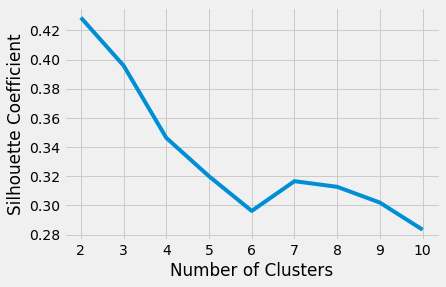

In [68]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [69]:
number_cluster=np.argmax(silhouette_coefficients)+2
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans_cluster=kmeans.fit_predict(scaled_features,sample_weight=df['SEGMENTS'])
score = silhouette_score(scaled_features, kmeans.labels_).round (2)
f"optimal Number of Cluster:{number_cluster}, Score:{score}"

'optimal Number of Cluster:2, Score:0.4'

## Inteperting Clustering Results

In [82]:
def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()

    def tree_dfs(node_id=0, current_rule=[]):
        # feature[i] holds the feature to split on, for the internal node i.
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
            # left child
            left_rule = current_rule + [{name+"_RULE":f"<= {threshold}"}]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
            # right child
            right_rule = current_rule + [{name+"_RULE":f"> {threshold}"}]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = ["ALL"]
            else:
                rule_string = current_rule
            # register new rule to dictionary
            selected_class = classes[max_idx]
            class_probability = dist[max_idx]
            class_rules = class_rules_dict.get(selected_class, [])
            class_rules.append(rule_string+ [{"concentration":class_probability}])
            class_rules_dict[selected_class] = class_rules
    
    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)
    rules_df = pd.DataFrame(columns=features.columns.to_series().add_suffix('_RULE').index.tolist()+['concentration','cluster_id'])
    report_class_list=[]
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        temp={}
        for rule in rule_list:
            for value_ in rule:
                if value_!='ALL':
                    temp.update(value_)
            temp['cluster_id']=class_name
            rules_df=pd.concat([rules_df,pd.DataFrame([temp])])
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['cluster_id', 'instance_count']
    # report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, rules_df, on='cluster_id', how='left')
   
    return report_df

In [83]:
data=cluster_report(features,kmeans_cluster).fillna('')

In [84]:
array_=pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_))

In [85]:
data

,cluster_id,instance_count,ALIVE_PROB_RULE,FUTURE_12MO_PURCHASE_RULE,concentration
0,1,35,,,0.492958
1,0,19,,,
2,2,17,,,


In [36]:
features.shape[0]

184

In [85]:
array_['multiplier']=(array_[0]*array_[1])
array_['cluster_id']=array_.index.values

In [86]:
array_['cluster_segments']=pd.qcut(array_['multiplier'],3,labels=['Low Engaged','Medium Engaged','High Engaged'])

In [87]:
pd.merge(data,array_.drop([0,1,'multiplier'],axis=1),left_on='cluster_id',right_on="cluster_id")

,cluster_id,instance_count,PROB_ALIVE_RULE,FREQ_FUTURE_12MO_PURCHASE_RULE,concentration,cluster_segments
0,1,462,> 0.5849999785423279,<= 23.355000495910645,0.993450,Medium Engaged
1,0,415,<= 0.5849999785423279,,0.983294,Low Engaged
2,2,51,> 0.5849999785423279,> 23.355000495910645,1.000000,High Engaged


In [64]:
data.head()

,cluster_id,instance_count,PROB_ALIVE_RULE,FREQ_FUTURE_12MO_PURCHASE_RULE,concentration
0,1,462,> 0.5849999785423279,<= 23.355000495910645,0.993450
1,0,415,<= 0.5849999785423279,,0.983294
2,2,51,> 0.5849999785423279,> 23.355000495910645,1.000000


In [66]:
temp=pd.DataFrame()

In [67]:
temp['cluster_segments']=

In [ ]:
temp['cluster_segments']=

In [49]:
data['cluster_id']=



SyntaxError: invalid syntax (751437359.py, line 1)

In [26]:
#Appending model params to model checkpoints table
f = '%Y-%m-%d %H:%M:%S'
timestamp_now = datetime.datetime.now().strftime(f)   

data['timestamp']=timestamp_now

# Model Version, Get the latest model Number
model_number=client.query(f"SELECT max(model_no) FROM `{CHECKPOINTS_TABLE}`").to_dataframe()
if model_number.isna().values[0]:
    model_number=1
else:
    model_number+=1
    
data['model_no']=model_number
model_filename = f"kmeans_model_{model_number.values[0][0]}.joblib"
joblib.dump(kmeans, model_filename)

# # Upload the model to GCS
bucket_path="model_checkpoints/cltv_model"
bucket = storage.Client(project=PROJECT_NAME).bucket("cdp-dev-ai-ml")
blob = bucket.blob('{}/{}'.format(
    bucket_path,
    model_filename))
blob.upload_from_filename(model_filename)
# data['model_path']=model_filename    

print(data)
    
# data=[{"timestamp":timestamp_now,'pareto_nbd_metric':eval(pnf_fitter_param.to_json()),'gamma_gamma_metric':eval(ggf_fitter_param.to_json()),'rmse':rmse}]

# errors=client.insert_rows_json(CHECKPOINTS_TABLE,eval(data.to_json(orient='records')))

if errors == []:
    print("New rows have been added.")
else:
    print("Encountered errors while inserting rows: {}".format(errors))

   class_name  instance_count        PROB_ALIVE_rule  \
0           1             462   > 0.5849999785423279   
1           0             415  <= 0.5849999785423279   
2           2              51   > 0.5849999785423279   

  FREQ_FUTURE_12MO_PURCHASE_rule  concentration            timestamp  model_no  
0          <= 23.355000495910645       0.993450  2022-05-06 04:43:41       5.0  
1                                      0.983294  2022-05-06 04:43:41       NaN  
2           > 23.355000495910645       1.000000  2022-05-06 04:43:41       NaN  


NameError: name 'errors' is not defined

In [ ]:
concentration= alive_prob_rule = future_12m_rule =Done


which cluster to target?

    Alive >  and future_12m_purchase ==> Decision
    
    
70M records? ==> Groubby ==> weighted_kmeans ==> Done


In [267]:
scaler.inverse_transform(kmeans.cluster_centers_)

array([[ 0.83464653,  9.1068201 ],
       [ 0.33122119,  1.08785686],
       [ 0.95028381, 37.91683702]])

### Model  Batch Prediction

In [11]:
sample_records=client.query(f"select alive_prob,future_12m_purchase,customer_id from {CLTV_PREDICTIONS_TABLE} limit 10000000").to_dataframe().set_index('customer_id')

In [12]:
%%time
scaled_features=scaler.transform(sample_records)

CPU times: user 89.2 ms, sys: 77.6 ms, total: 167 ms
Wall time: 165 ms


In [13]:
%%time
kmeans_cluster=kmeans.predict(scaled_features)

CPU times: user 609 ms, sys: 246 ms, total: 855 ms
Wall time: 727 ms


In [14]:
kmeans_cluster

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [242]:
sample_records['cluster_id']=kmeans_cluster

In [248]:
sample_records.head(20000)

,alive_prob,future_12m_purchase,cluster_id
customer_id,,,
2567,1.00000,5.239709,0
3772,1.00000,5.239709,0
5607,1.00000,5.239709,0
5631,1.00000,5.239709,0
7105,1.00000,5.239709,0
...,...,...,...
679,0.32145,0.629957,1
3621,0.32145,0.629957,1
5989,0.32145,0.629957,1


In [247]:
sample_records.tail(20000)

,alive_prob,future_12m_purchase,cluster_id
customer_id,,,
12444,0.974413,23.881556,2
12497,0.974413,23.881556,2
13279,0.974413,23.881556,2
14574,0.974413,23.881556,2
14751,0.974413,23.881556,2
...,...,...,...
958,0.347802,0.716739,1
2980,0.347802,0.716739,1
3754,0.347802,0.716739,1
